# Webpage Granularity

## 1. PRE-PROCESS: remove stopwords - make bigrams - make trigrams - lemmatization - dictionary - corpus

In [2]:
import json
# Enable logging for gensim - optional
import logging
import re
import warnings
from collections import defaultdict, Counter

import gensim
import gensim.corpora as corpora
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import spacy
from wordcloud import WordCloud, STOPWORDS
from gensim.models import CoherenceModel, TfidfModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


warnings.filterwarnings("ignore", category=DeprecationWarning)

# import training data

with open('train_data.json', 'r') as f:
    train_data = json.load(f)


link = []
category = []
body_par = []
comment_par = []

for item in train_data:
    link.append(item['link'])
    category.append(item['category'])
    body_par.append(item['body_par'])
    comment_par.append(item['comment_par'])


# nltk.download('stopwords')  # (run python console)
# python3 -m spacy download en  # (run in terminal)

# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend([])

# Tokenize words and remove punctuations and unnecessary characters


def sent_to_words(webpages):
    pages = []
    for webpage in webpages:
        pars = []
        for paragraph in webpage:
            # simeple preprocess remove also digits
            # deacc=True removes punctuations
            pars = pars + simple_preprocess(str(paragraph), deacc=True)

        pages.append(pars)

    return pages


# turn a generator into a list
train_words = list(sent_to_words(body_par))

# num characters for each paragraph
print('Lenght words for each webpage: \n\n',
      [len(word) for word in train_words])
print('-' * 20)
print('\n')

# Train Bigram and Trigram Models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(train_words, min_count=5, threshold=40)
trigram = gensim.models.Phrases(bigram[train_words], threshold=40)

# Faster way to get a paragraph clubbed as trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# vis words with underscore
words_list = trigram_mod[bigram_mod[train_words]]

# Frequency of n-gram words
dist = nltk.FreqDist(
    [word for par in words_list for word in par if '_' in word])

# Sort frequency
print('Sorted trigrams: \n')
print(sorted(dist.items(), key=lambda x: x[1], reverse=True))
print('-'*20)

Lenght words for each webpage: 

 [781, 591, 194, 849, 1435, 2351, 1556, 749, 965, 1494, 1785, 1179, 5402, 1401, 433, 3255, 3449, 1764, 1295, 1999, 698, 601, 667, 387, 548, 283, 1319, 154]
--------------------


Sorted trigrams: 

[('smart_home', 93), ('such_as', 65), ('connected_devices', 39), ('have_been', 28), ('personal_information', 26), ('has_been', 25), ('for_example', 25), ('do_not', 24), ('iot_devices', 23), ('home_automation', 19), ('you_re', 18), ('united_states', 17), ('as_well_as', 17), ('based_on', 15), ('smart_speakers', 15), ('for_instance', 15), ('does_not', 15), ('credential_stuffing', 14), ('smart_speaker', 13), ('consumers_international', 13), ('data_collection', 12), ('google_assistant', 12), ('he_said', 12), ('an_individual', 12), ('focus_on', 12), ('internet_society', 12), ('smart_homes', 12), ('associated_with', 11), ('control_over', 11), ('amazon_alexa', 10), ('opt_out', 10), ('you_ll', 9), ('find_out', 8), ('rely_on', 8), ('years_ago', 8), ('attack_skill', 8),

In [3]:
# Remove stopwords


def remove_stopwords(texts):
    '''
    Input: words' paragraphs
    OUtput: words' paragraphs without stop words
    '''
    par_words = list(sent_to_words(texts))

    return [[word for word in page if word not in stop_words] for page in par_words]


def make_bigrams(texts):
    '''
    Input: words' paragraphs without stop words
    Output: bigram model
    '''
    return [bigram_mod[page] for page in texts]


def make_trigrams(texts):
    '''
    Input: words' paragraphs without stop words
    Output: trigram model
    '''
    return [trigram_mod[bigram_mod[page]] for page in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    '''
    Input: words' paragraphs without stop words
    OUtput: words' paragraphs without stop words and lemmatization
    https://spacy.io/api/annotation
    '''

    texts_out = []
    for page_words in texts:
        # join single words to a unique string of text
        page_text = nlp(' '.join(page_words))
        # return token (word) lemma if part of speech (pos) within allowed
        texts_out.append(
            [token.lemma_ for token in page_text if token.pos_ in allowed_postags])

    return texts_out


# Remove Stop Words
train_words_nostop = remove_stopwords(body_par)

# Form trigrams
train_words_bigrams = make_bigrams(train_words_nostop)
train_words_trigrams = make_trigrams(train_words_nostop)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv as per default
train_words_lemmatized = lemmatization(train_words_trigrams)

# Create Dictionary
id2word = corpora.Dictionary(train_words_lemmatized)

# Create Corpus
texts = train_words_lemmatized

# Term Document Frequency >> (id, freq) for each page
corpus = [id2word.doc2bow(text) for text in texts]

print('\nPrint words and frequencies in the first website:\n')
print([[(id2word[id], freq) for id, freq in page] for page in corpus[:1]])
print('-' * 20)


Print words and frequencies in the first website:

[[('ability', 1), ('access', 3), ('accessibility', 1), ('account', 5), ('add', 1), ('adjust', 1), ('alarm', 1), ('allow', 3), ('also', 3), ('always', 1), ('amazon_echo', 2), ('analyze', 1), ('anticipate', 1), ('app', 2), ('appliance', 1), ('application', 1), ('apply', 2), ('ask', 1), ('assistant', 1), ('associate', 1), ('auto', 1), ('available', 4), ('become', 2), ('begin', 1), ('big', 1), ('birth', 1), ('bulb', 1), ('change', 2), ('chat', 1), ('code', 1), ('collect', 1), ('combination', 1), ('come', 2), ('command', 1), ('complete', 1), ('compromise', 1), ('concern', 1), ('connect', 3), ('connected', 1), ('connectivity', 3), ('consider', 1), ('console', 3), ('consumer', 1), ('content', 1), ('control', 2), ('convenience', 1), ('create', 1), ('credential', 1), ('customize', 1), ('cybercriminal', 2), ('cybersecurity', 1), ('daily', 1), ('data_collection', 1), ('date', 3), ('datum', 3), ('determine', 1), ('device', 22), ('devices', 1), ('

### TF-IDF

In [4]:
# Create the TF-IDF model
# Term frequency = 'n' (Occurence frequency of term in document)
# Document frequency = 't' (non-zero inverse collection frequency)
# Document lenght normalization = 'c' (cosine normalization)
tfidf = TfidfModel(corpus, smartirs='ntc')

tfidf_list = []

for page in tfidf[corpus]:
    tfidf_list = tfidf_list + \
        [(id2word[id], np.around(freq, decimals=3)) for id, freq in page]

# Sort frequency
# Convert list of tuples to dictionary value lists

tfidf_dict = defaultdict(list)
for idx, tfidf_num in tfidf_list:
    tfidf_dict[idx].append(tfidf_num)

print('\nTF-IDF for each words: \n')
sorted_tfidf = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)

# Smallest TF-IDF: words commonly used across all documents and rarely used in the particular document.
print('Smallest 10 tfidf:\n{}\n'.format(sorted_tfidf[:-11:-1]))

# Largest TF-IDF: Term that appears frequently in a particular document, but not often in the corpus.
print('Largest 10 tfidf: \n{}'.format(sorted_tfidf[:11]))
print('-' * 20)


TF-IDF for each words: 

Smallest 10 tfidf:
[('feel', [0.005, 0.011, 0.01, 0.01, 0.003, 0.02, 0.006, 0.017, 0.019, 0.009, 0.01, 0.013, 0.023, 0.012]), ('much', [0.005, 0.011, 0.011, 0.01, 0.01, 0.02, 0.006, 0.009, 0.057, 0.038, 0.015, 0.013, 0.02, 0.012]), ('work', [0.006, 0.004, 0.004, 0.008, 0.017, 0.036, 0.007, 0.016, 0.008, 0.005, 0.006, 0.013, 0.024, 0.012, 0.019, 0.029]), ('sense', [0.006, 0.012, 0.013, 0.013, 0.02, 0.01, 0.008, 0.006, 0.013, 0.007, 0.016]), ('early', [0.006, 0.013, 0.015, 0.013, 0.008, 0.026, 0.008, 0.013, 0.013, 0.013, 0.016]), ('reduce', [0.006, 0.015, 0.006, 0.018, 0.01, 0.025, 0.023]), ('experience', [0.006, 0.016, 0.012, 0.026, 0.003, 0.014, 0.032, 0.01, 0.005, 0.038, 0.088, 0.025, 0.039]), ('enhance', [0.006, 0.032, 0.02, 0.009, 0.041, 0.037]), ('reach', [0.006, 0.043, 0.011, 0.027, 0.034, 0.026]), ('influence', [0.006, 0.043, 0.027, 0.009, 0.011, 0.026])]

Largest 10 tfidf: 
[('bot', [0.687]), ('skill', [0.598, 0.015, 0.026, 0.013]), ('accenture', [0.465

## 2. LDA model

In [5]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,  # take all documents into account
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


print('\n LDA model topics: \n')
for topic, keyword in lda_model.print_topics():
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)


 LDA model topics: 

Topic:  0
Keywords:  0.051*"privacy" + 0.021*"information" + 0.011*"individual" + 0.011*"right" + 0.007*"use" + 0.007*"protection" + 0.007*"private" + 0.007*"control" + 0.006*"law" + 0.006*"self"
Topic:  1
Keywords:  0.020*"bot" + 0.013*"homebot" + 0.011*"home" + 0.011*"consumer" + 0.008*"smart_home" + 0.008*"new" + 0.007*"ai" + 0.007*"service" + 0.007*"product" + 0.007*"need"
Topic:  2
Keywords:  0.033*"skill" + 0.019*"attack" + 0.013*"user" + 0.013*"alexa" + 0.013*"voice" + 0.011*"google" + 0.010*"researcher" + 0.009*"attack_skill" + 0.008*"example" + 0.007*"home"
Topic:  3
Keywords:  0.023*"device" + 0.015*"smart_home" + 0.015*"trust" + 0.014*"smart" + 0.014*"percent" + 0.013*"technology" + 0.010*"service" + 0.009*"security" + 0.008*"people" + 0.007*"consumer"
Topic:  4
Keywords:  0.048*"security" + 0.021*"nest" + 0.016*"say" + 0.011*"use" + 0.009*"user" + 0.009*"google" + 0.008*"system" + 0.008*"password" + 0.007*"people" + 0.006*"account"
Topic:  5
Keywords: 

In [10]:
# Compute model perplexity and coherence score
# a measure of how good the model is. lower the better.
print('\nPerplexity and Choerence Score for LDA model:')
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=train_words_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)
print('-'*20)


Perplexity and Choerence Score for LDA model:

Perplexity:  -7.379077589472722
Coherence Score:  0.4935830923714183
--------------------


In [47]:
# Visualize the topics
warnings.filterwarnings("ignore", category=FutureWarning)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.100395 -0.016775       1        1  18.499855
0     -0.096862  0.141631       2        1  15.971748
7      0.048300  0.092803       3        1  15.255119
4      0.013977  0.083791       4        1  10.544478
5      0.131187 -0.010933       5        1  10.543769
3      0.071796  0.005978       6        1   9.101252
8     -0.203546 -0.023865       7        1   8.727607
1     -0.008628 -0.092426       8        1   5.470219
9     -0.019360 -0.090230       9        1   3.490859
2     -0.037258 -0.089974      10        1   2.395094, topic_info=     Category        Freq      Term       Total  loglift  logprob
1737  Default  190.000000     trust  190.000000  30.0000  30.0000
158   Default  262.000000   privacy  262.000000  29.0000  29.0000
183   Default  212.000000  security  212.000000  28.0000  28.0000
42    Default  131.000000  consumer  131.000000  27.0000  27.0000
56    Default  191.000000    device  191.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
92    Topic10    3.431496      home  135.108154   0.0587  -4.9436
392   Topic10    2.276401   similar   18.638607   1.6291  -5.3540
383   Topic10    2.866844       say   89.830093   0.2870  -5.1234
8     Topic10    2.292162      also   70.073822   0.3117  -5.3471
183   Topic10    1.841139  security  212.805786  -1.0182  -5.5662

[697 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
235       1  0.359551    able
235       2  0.102729    able
235       4  0.102729    able
235       5  0.154093    able
235       6  0.051364    able
...     ...       ...     ...
3487      8  0.647142     win
3488      8  0.873247  winner
1423      1  0.844379     wue
3348      5  0.900615  yearly
2592      2  0.859346   young

[1737 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 8, 5, 6, 4, 9, 2, 10, 3])

In [13]:
%%capture
# Build LDA Mallet Model
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(
    mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

In [14]:
print('\n LDA Mallet model topics: \n')
for topic, keyword in ldamallet.show_topics(formatted=False):
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)

coherence_model_ldamallet = CoherenceModel(
    model=ldamallet, texts=train_words_lemmatized, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# Choerence score lower than lda_model
print('Choerence Score for LDA Mallet model:')
print('\nCoherence Score: ', coherence_ldamallet)
print('-'*20)


 LDA Mallet model topics: 

Topic:  0
Keywords:  [('device', 0.0382934978154716), ('home', 0.0359804677460807), ('smart_home', 0.026471344127473657), ('service', 0.017476227190953483), ('product', 0.017219223849910047), ('datum', 0.01670521716782318), ('technology', 0.01593420714469288), ('system', 0.015163197121562581), ('smart', 0.014135183757388847), ('consumer', 0.01156515034695451)]
Topic:  1
Keywords:  [('security', 0.06271536871123363), ('user', 0.039283252929014474), ('nest', 0.02101998621640248), ('google', 0.013439007580978636), ('system', 0.013094417643004824), ('make', 0.012749827705031013), ('include', 0.012405237767057202), ('skill', 0.011371467953135768), ('year', 0.011026878015161957), ('attack', 0.010682288077188146)]
Topic:  2
Keywords:  [('company', 0.020710059171597635), ('siri', 0.020441097364174286), ('device', 0.014523937600860678), ('alexa', 0.013986013986013986), ('voice', 0.013986013986013986), ('smart', 0.013448090371167294), ('recording', 0.0131791285637439

### Automatically find the optimal number of topics

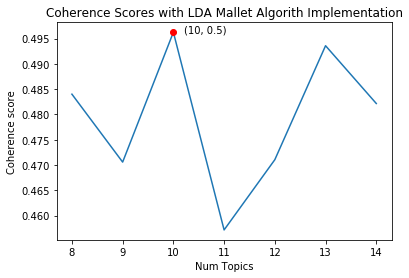

In [16]:

def LdaMallet_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    '''
    Compute c_v coherence for various number of topics
    
    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limit: max num of topics
    
    Returns:
    ---------
    model_list: list of LDA topic models
    coherence_values: corresponding to the LDA model
    '''

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def LDA_coherence_values(dictionary, corpus, texts, limit, chunksize = 100, start=2, step=3):
    '''
    Compute c_v coherence for various number of topics

    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input text 
    chunksize: number of documents to be used in each training chunk
    limit: max num of topics

    Returns:
    ---------
    model_list: list of LDA topic
    coherence_values: corresponding to the LDA model
    '''

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                                num_topics=num_topics, random_state=100, 
                                                update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


model_list_mallet, coherence_values_mallet = LdaMallet_coherence_values(dictionary=id2word, corpus=corpus, 
                                                          texts=train_words_lemmatized, start=8, limit=15, step=1)

# show graph
limit = 15
start=8
step=1
x = range(start, limit, step)
plt.figure(figsize=(8,3), dpi=160)
plt.plot(x, coherence_values_mallet)
plt.plot(x[np.argmax(coherence_values_mallet)], max(coherence_values_mallet), 'or')
plt.text(x[np.argmax(coherence_values_mallet)]+0.2, max(coherence_values_mallet), 
         r'({}, {})'.format(x[np.argmax(coherence_values_mallet)], np.round(max(coherence_values_mallet), 2)))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.title('Coherence Scores with LDA Mallet Algorith Implementation')
# plt.savefig('output/Topics_Coher_LDA_Mallet_page')
plt.show()

In [17]:
print('\nLDA Mallet: \n')
for num, cv in zip(x, coherence_values_mallet):
    print('Nun Topics =', num, ' has Coherence Value of', round(cv, 4))
print('-'*20)


LDA Mallet: 

Nun Topics = 8  has Coherence Value of 0.484
Nun Topics = 9  has Coherence Value of 0.4706
Nun Topics = 10  has Coherence Value of 0.4963
Nun Topics = 11  has Coherence Value of 0.4572
Nun Topics = 12  has Coherence Value of 0.471
Nun Topics = 13  has Coherence Value of 0.4936
Nun Topics = 14  has Coherence Value of 0.4822
--------------------


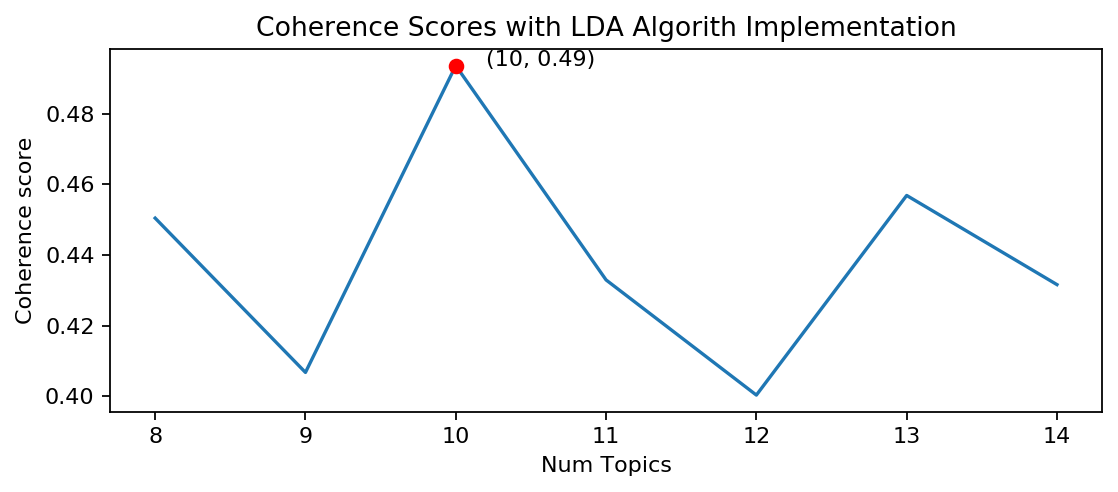

In [32]:
model_list, coherence_values = LDA_coherence_values(dictionary=id2word, corpus=corpus, 
                                                          texts=train_words_lemmatized, start=8, limit=15, step=1)

# show graph
limit = 15
start=8
step=1
x = range(start, limit, step)
plt.figure(figsize=(8,3), dpi=160)
plt.plot(x, coherence_values)
plt.plot(x[np.argmax(coherence_values)], max(coherence_values), 'or')
plt.text(x[np.argmax(coherence_values)]+0.2, max(coherence_values), 
         r'({}, {})'.format(x[np.argmax(coherence_values)], np.round(max(coherence_values), 2)))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.title('Coherence Scores with LDA Algorith Implementation')
# plt.savefig('output/Topics_Coher_LDA_Model_page')
plt.show()

In [19]:
print('\nLDA model: \n')
for num, cv in zip(x, coherence_values):
    print('Nun Topics =', num, ' has Coherence Value of', round(cv, 4))
print('-'*20)


LDA model: 

Nun Topics = 8  has Coherence Value of 0.4504
Nun Topics = 9  has Coherence Value of 0.4067
Nun Topics = 10  has Coherence Value of 0.4936
Nun Topics = 11  has Coherence Value of 0.4329
Nun Topics = 12  has Coherence Value of 0.4003
Nun Topics = 13  has Coherence Value of 0.4568
Nun Topics = 14  has Coherence Value of 0.4316
--------------------


In [20]:
# pick the model with the highest coherence score
if max(coherence_values_mallet) > max(coherence_values):
    optimal_model = model_list_mallet[np.argmax(coherence_values_mallet)]
else:
    optimal_model = model_list[np.argmax(coherence_values)]

model_topics = optimal_model.show_topics(formatted = False)

print('\n LDA Mallet topics: \n')
for topic, keyword in optimal_model.print_topics(num_words=10):
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)


 LDA Mallet topics: 

Topic:  0
Keywords:  0.109*"privacy" + 0.055*"information" + 0.024*"individual" + 0.020*"protection" + 0.015*"control" + 0.015*"include" + 0.013*"access" + 0.013*"state" + 0.012*"personal_information" + 0.011*"person"
Topic:  1
Keywords:  0.136*"trust" + 0.029*"group" + 0.026*"social" + 0.017*"relationship" + 0.013*"increase" + 0.012*"economic" + 0.011*"lead" + 0.011*"game" + 0.009*"identity" + 0.008*"interest"
Topic:  2
Keywords:  0.072*"consumer" + 0.051*"device" + 0.043*"security" + 0.027*"privacy" + 0.020*"iot" + 0.019*"connected_device" + 0.018*"connect" + 0.017*"people" + 0.017*"survey" + 0.015*"digital"
Topic:  3
Keywords:  0.104*"security" + 0.040*"nest" + 0.018*"account" + 0.016*"include" + 0.016*"password" + 0.014*"software" + 0.014*"hack" + 0.014*"computer" + 0.012*"system" + 0.010*"people"
Topic:  4
Keywords:  0.058*"siri" + 0.029*"assistant" + 0.028*"voice" + 0.028*"apple" + 0.025*"setting" + 0.017*"tap" + 0.016*"alexa" + 0.015*"recording" + 0.015*"l

## STATS AND VISUALIZATIONS
1. Find the dominant topic for each webpage

In [21]:
# Find the dominant topic in each sentence
# Find the topic number with the highest percentage contributio in that document

def dominant_topic(ldamodel = lda_model, corpus=corpus, texts=body_par):
    # init dataframe
    topics_df = pd.DataFrame()

    # GET MAIN TOPIC IN EACH WEBPAGE
    # Get throught the pages
    for num, page in enumerate(ldamodel[corpus]):
        # Count number of list into a list
        if sum(isinstance(i, list) for i in page)>0:
            page = page[0]

        page = sorted(page, key= lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(page):
            if j == 0: # => dominant topic
                # Get list prob. * keywords from the topic
                pk = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in pk])
                # Add topic number, probability, keywords and original text to the dataframe
                topics_df = topics_df.append(pd.Series([int(topic_num), np.round(prop_topic, 4),
                                                    topic_keywords, texts[num]]),
                                                    ignore_index=True)
            else:
                break
                
    # Add columns name
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

    return topics_df


df_topic_keywords = dominant_topic(ldamodel=optimal_model, corpus=corpus, texts=body_par)

In [25]:
# Expand display output in terminal
pd.options.display.max_colwidth = 100

df_topic_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2.0,0.2448,"consumer, device, security, privacy, iot, connected_device, connect, people, survey, digital",[Did you ever wonder what it would be like to have a smart home? You could remotely change the t...
1,9.0,0.1583,"smart, home, smart_home, control, door, device, time, system, camera, service",[Sales of smart home-related products are growing at double-digit rates in many countries across...
2,8.0,0.2552,"company, device, datum, amazon, user, percent, app, recording, report, smart_speaker",[A user of Amazon’s Alexa voice assistant in Germany got access to more than a thousand recordin...
3,6.0,0.7366,"user, google, provide, home, skill, make, attack, similar, alexa, check","[Oh, goody, Amazon Alexa and/or Google Home could be hit with remote, large-scale “voice squatti..."
4,4.0,0.6856,"siri, assistant, voice, apple, setting, tap, alexa, recording, listen, click","[At their best, voice assistants from the likes of Microsoft, Apple, Google, Samsung, and Amazon..."
5,3.0,0.5063,"security, nest, account, include, password, software, hack, computer, system, people","[Tara Thomas thought her daughter was just having nightmares. “There’s a monster in my room,” th..."
6,8.0,0.4130,"company, device, datum, amazon, user, percent, app, recording, report, smart_speaker","[Is privacy over?, That may not exactly be a new question, but the proficiency with which tech g..."
7,4.0,0.3398,"siri, assistant, voice, apple, setting, tap, alexa, recording, listen, click","[At Apple, we believe privacy is a fundamental human right. We design our products to protect us..."
8,4.0,0.3736,"siri, assistant, voice, apple, setting, tap, alexa, recording, listen, click","[Apple contractors regularly hear confidential medical information, drug deals, and recordings o..."
9,8.0,0.4532,"company, device, datum, amazon, user, percent, app, recording, report, smart_speaker","[Internet-connected products have become enmeshed in many aspects of daily life, both at home an..."


2. Find the most representative document for each topic in order to infer the topic

In [26]:
# Find the most representative document for each topic in order to infer the topic

df_topic_sorted = pd.DataFrame()
df_topic_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topic_grouped:
    # populate the sorted dataframe with the page that contributed the most to the topic
    df_topic_sorted = pd.concat([df_topic_sorted, grp.sort_values(['Perc_Contribution'], ascending = [0]).head(1)], axis = 0)
    
# Reset Index and change columns name
df_topic_sorted.reset_index(drop = True, inplace = True)
df_topic_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [27]:
df_topic_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5795,"privacy, information, individual, protection, control, include, access, state, personal_informat...","[Privacy is the ability of an individual or group to seclude themselves, or information about th..."
1,1.0,0.6649,"trust, group, social, relationship, increase, economic, lead, game, identity, interest","[In a social context, trust has several connotations. Definitions of trust typically refer to a ..."
2,2.0,0.6140,"consumer, device, security, privacy, iot, connected_device, connect, people, survey, digital",[This new research from Consumers International and the Internet Society explored consumer perce...
3,3.0,0.5217,"security, nest, account, include, password, software, hack, computer, system, people","[Security is freedom from, or resilience against, potential harm (or other unwanted coercive cha..."
4,4.0,0.6856,"siri, assistant, voice, apple, setting, tap, alexa, recording, listen, click","[At their best, voice assistants from the likes of Microsoft, Apple, Google, Samsung, and Amazon..."
5,5.0,0.4606,"datum, system, product, home, future, bot, smart_home, ai, place, solution",[The promise of devices that not only meet our household needs but anticipate them as well has b...
6,6.0,0.7366,"user, google, provide, home, skill, make, attack, similar, alexa, check","[Oh, goody, Amazon Alexa and/or Google Home could be hit with remote, large-scale “voice squatti..."
7,7.0,0.3236,"people, technology, human, give, part, find, create, personal, make, year","[If the 2017 holiday season was any evidence of the staying power of smart home technology, we a..."
8,8.0,0.4532,"company, device, datum, amazon, user, percent, app, recording, report, smart_speaker","[Internet-connected products have become enmeshed in many aspects of daily life, both at home an..."
9,9.0,0.7177,"smart, home, smart_home, control, door, device, time, system, camera, service","[Over two years ago, I converted my old ""dumb"" home into a still-old ""smart"" home., I've been us..."


3. Topic distribution across documents

In [28]:
# Topic distribution across documents
# To understand the volumne and distribution of topics in order to check how widely it was discussed

# Number of documents for each topic
topic_counts = df_topic_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for each Topic
topic_contribution = np.round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sorted[['Topic_Num', 'Keywords']].set_index(df_topic_sorted['Topic_Num'])

df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis = 1)

df_dominant_topics.reset_index(drop = True, inplace = True)
df_dominant_topics.columns = ['Topic_Num', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"privacy, information, individual, protection, control, include, access, state, personal_informat...",1,0.0357
1,1.0,"trust, group, social, relationship, increase, economic, lead, game, identity, interest",2,0.0714
2,2.0,"consumer, device, security, privacy, iot, connected_device, connect, people, survey, digital",4,0.1429
3,3.0,"security, nest, account, include, password, software, hack, computer, system, people",2,0.0714
4,4.0,"siri, assistant, voice, apple, setting, tap, alexa, recording, listen, click",3,0.1071
5,5.0,"datum, system, product, home, future, bot, smart_home, ai, place, solution",4,0.1429
6,6.0,"user, google, provide, home, skill, make, attack, similar, alexa, check",1,0.0357
7,7.0,"people, technology, human, give, part, find, create, personal, make, year",1,0.0357
8,8.0,"company, device, datum, amazon, user, percent, app, recording, report, smart_speaker",4,0.1429
9,9.0,"smart, home, smart_home, control, door, device, time, system, camera, service",6,0.2143


4. Frequency distribution of words count across documents

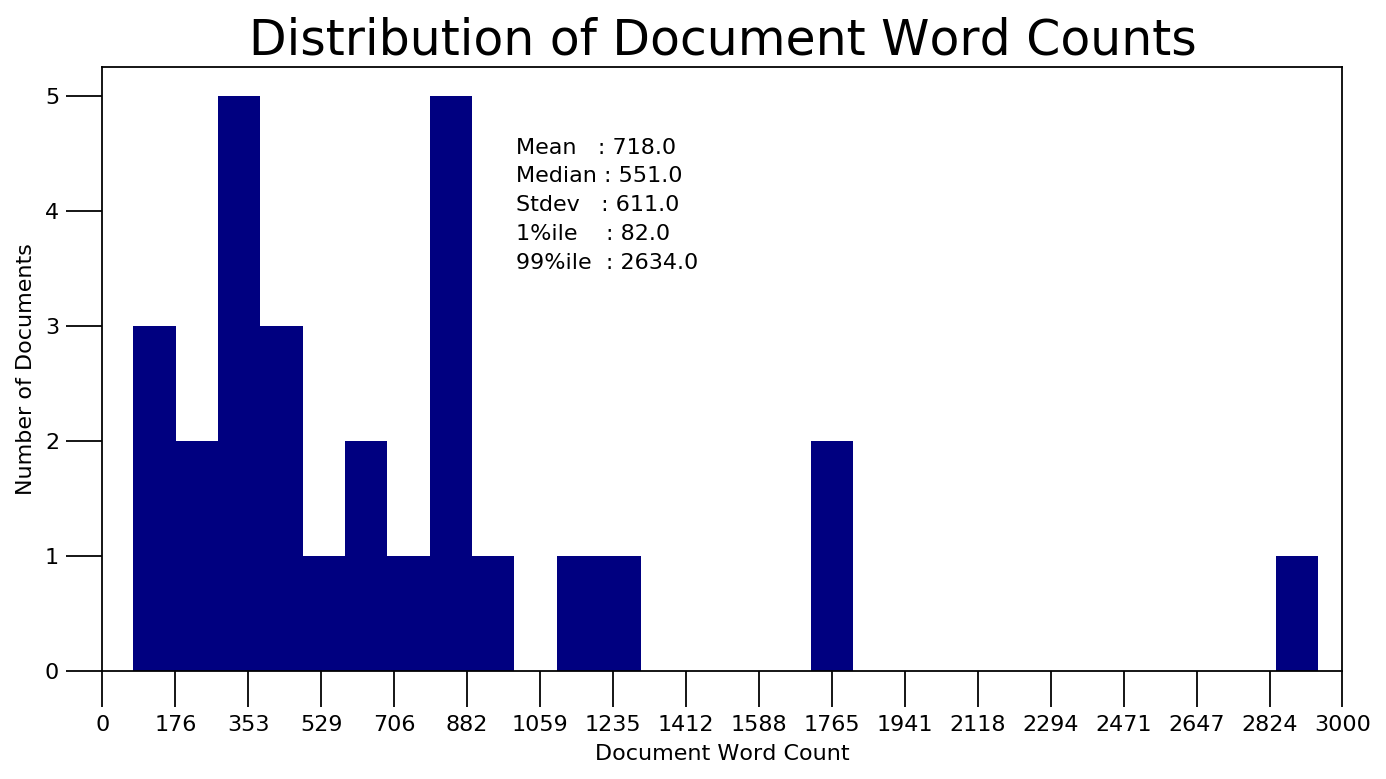

In [33]:
# Frequency distribution of word counts in documents
# How big the documents are as a whole in term of words count

df_topic_text = dominant_topic(ldamodel=optimal_model, corpus=corpus, texts=train_words_lemmatized)

words_len = [len(words) for words in df_topic_text.Text]

plt.figure(figsize=(10,5), dpi=160)
plt.hist(words_len, bins = 28, color='navy')
plt.text(1000, 4.5, "Mean   : " + str(round(np.mean(words_len))))
plt.text(1000,  4.25, "Median : " + str(round(np.median(words_len))))
plt.text(1000,  4, "Stdev   : " + str(round(np.std(words_len))))
plt.text(1000,  3.75, "1%ile    : " + str(round(np.quantile(words_len, q=0.01))))
plt.text(1000,  3.5, "99%ile  : " + str(round(np.quantile(words_len, q=0.99))))
plt.gca().set(xlim=(0, 3000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,3000,18))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

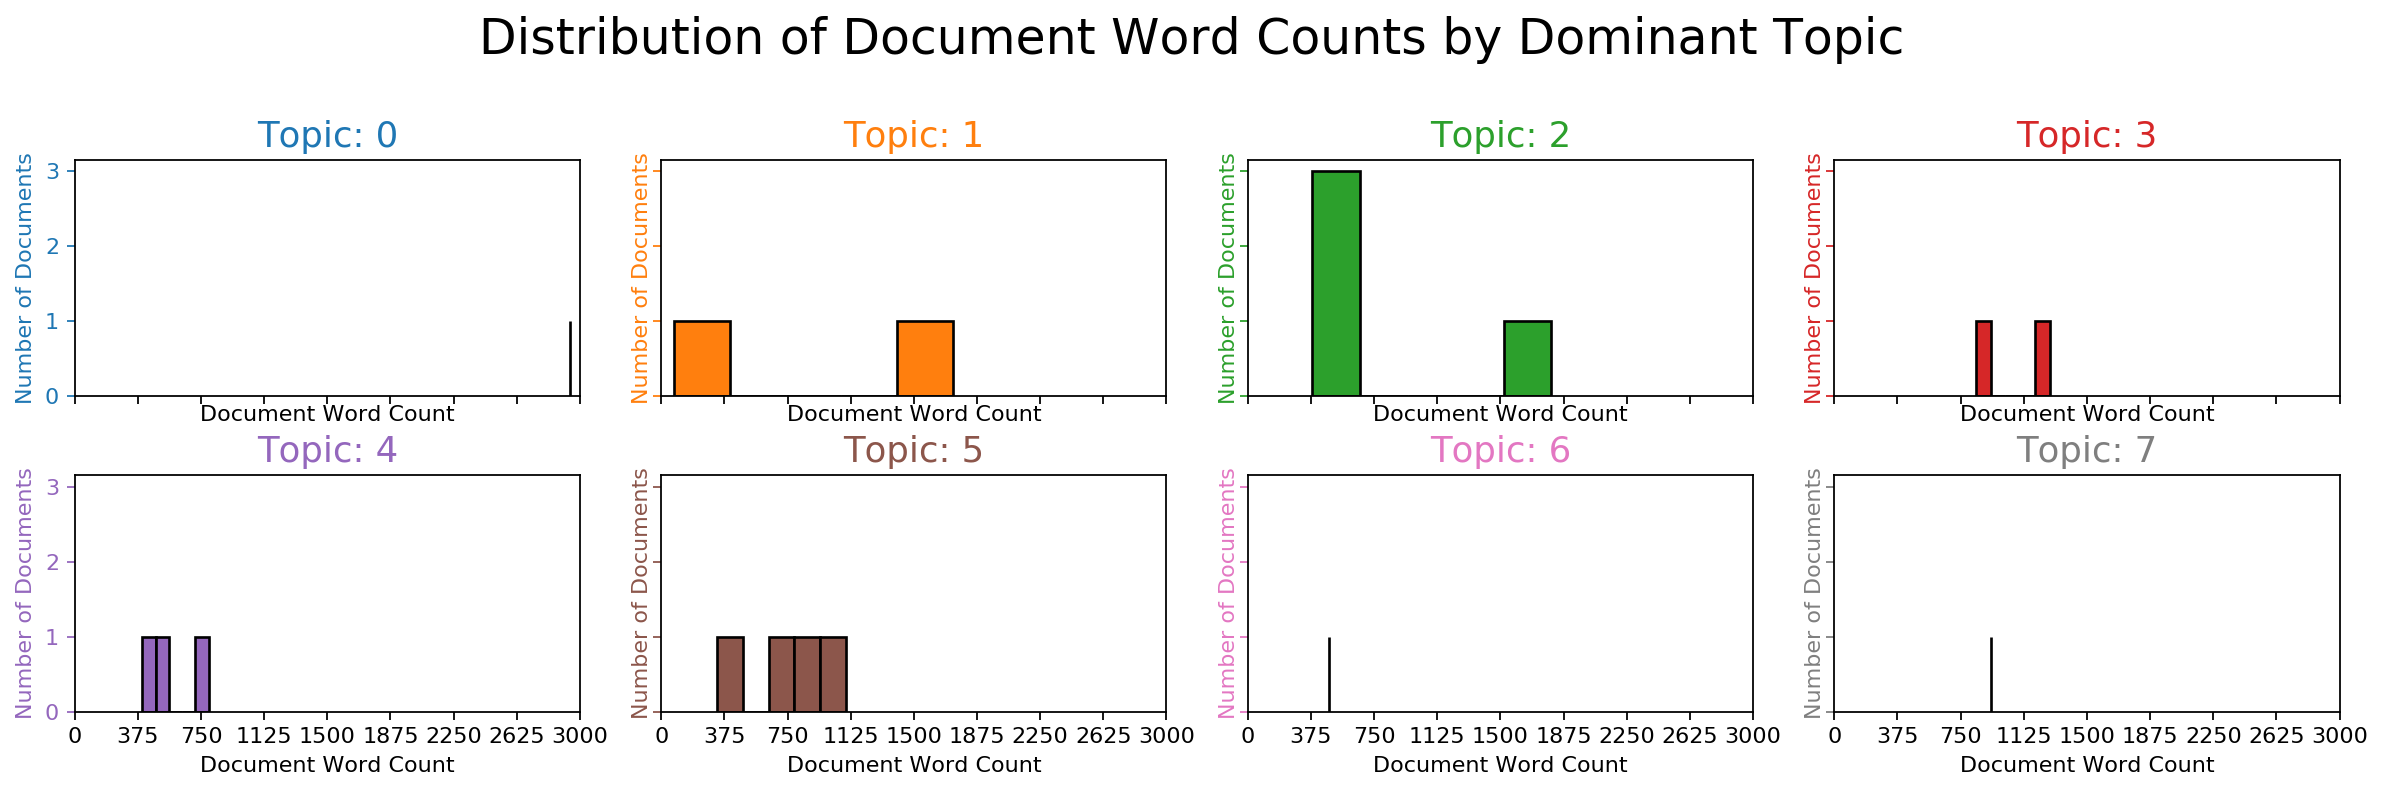

In [42]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

fig, axes = plt.subplots(2,4,figsize=(15,5), dpi=160, sharex=True, sharey=True)

# for each topic
for i, ax in enumerate(axes.flatten()):
    # Extract document within the specific topic
    df_topic_sub = df_topic_text.loc[df_topic_text.Dominant_Topic == i, :]
    topic_words_len = [len(words) for words in df_topic_sub.Text]
    ax.hist(topic_words_len, bins = 5, color = cols[i], edgecolor='black', linewidth=1.2)
    ax.tick_params(axis = 'y', labelcolor = cols[i], color = cols[i])
    ax.set(xlim=(0, 3000), xlabel = 'Document Word Count')
    ax.set_ylabel('Number of Documents', color = cols[i])
    ax.set_title('Topic: ' +str(i), fontdict = dict(size = 16, color = cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.80)
plt.xticks(np.linspace(0,3000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

5. Word Cloud

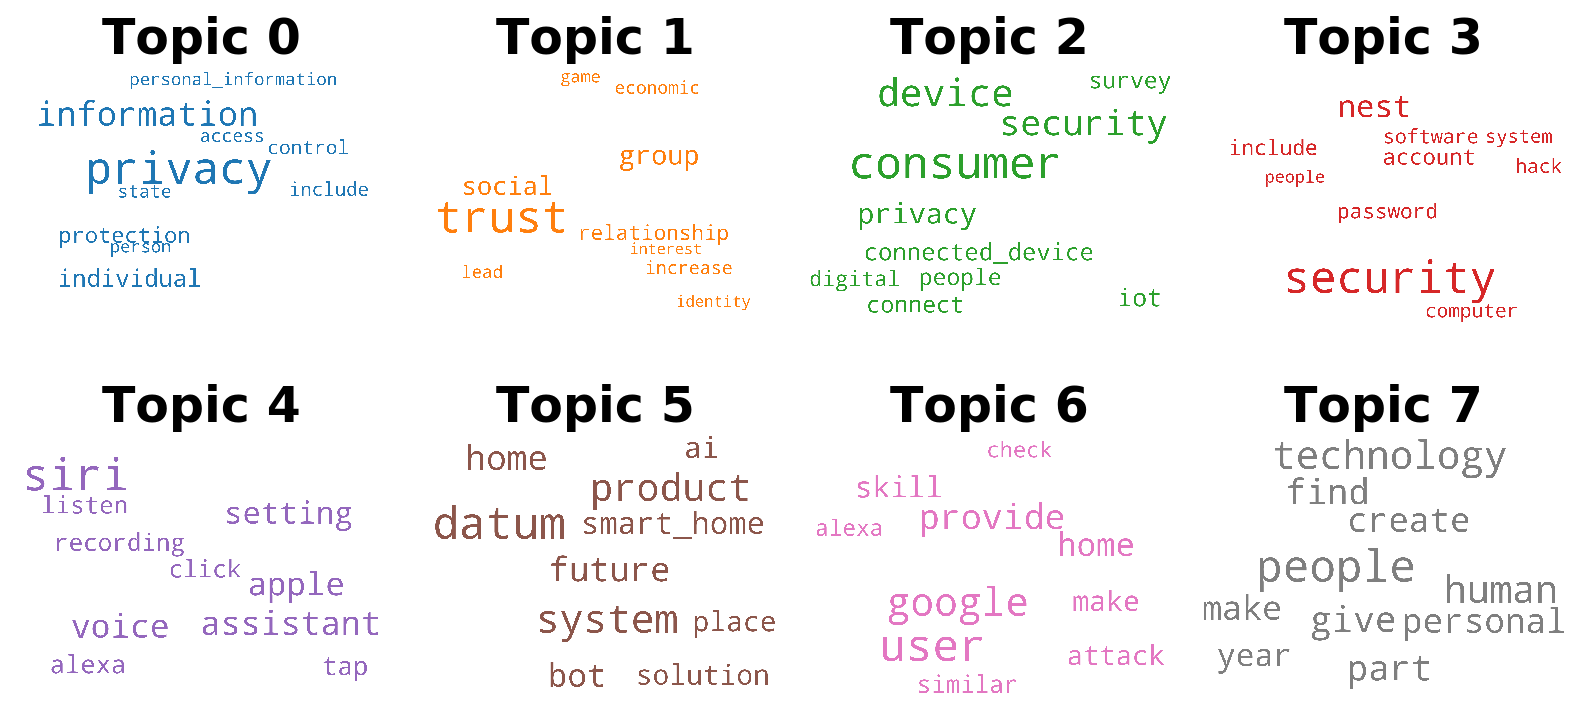

In [45]:
# Word coluds of Top N Keywords in Each Topic
# with the size of the words proportional to the weight

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)


fig, axes = plt.subplots(2, 4, figsize=(10,5), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=22, weight = 'bold'))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

6. Word frequency and weight

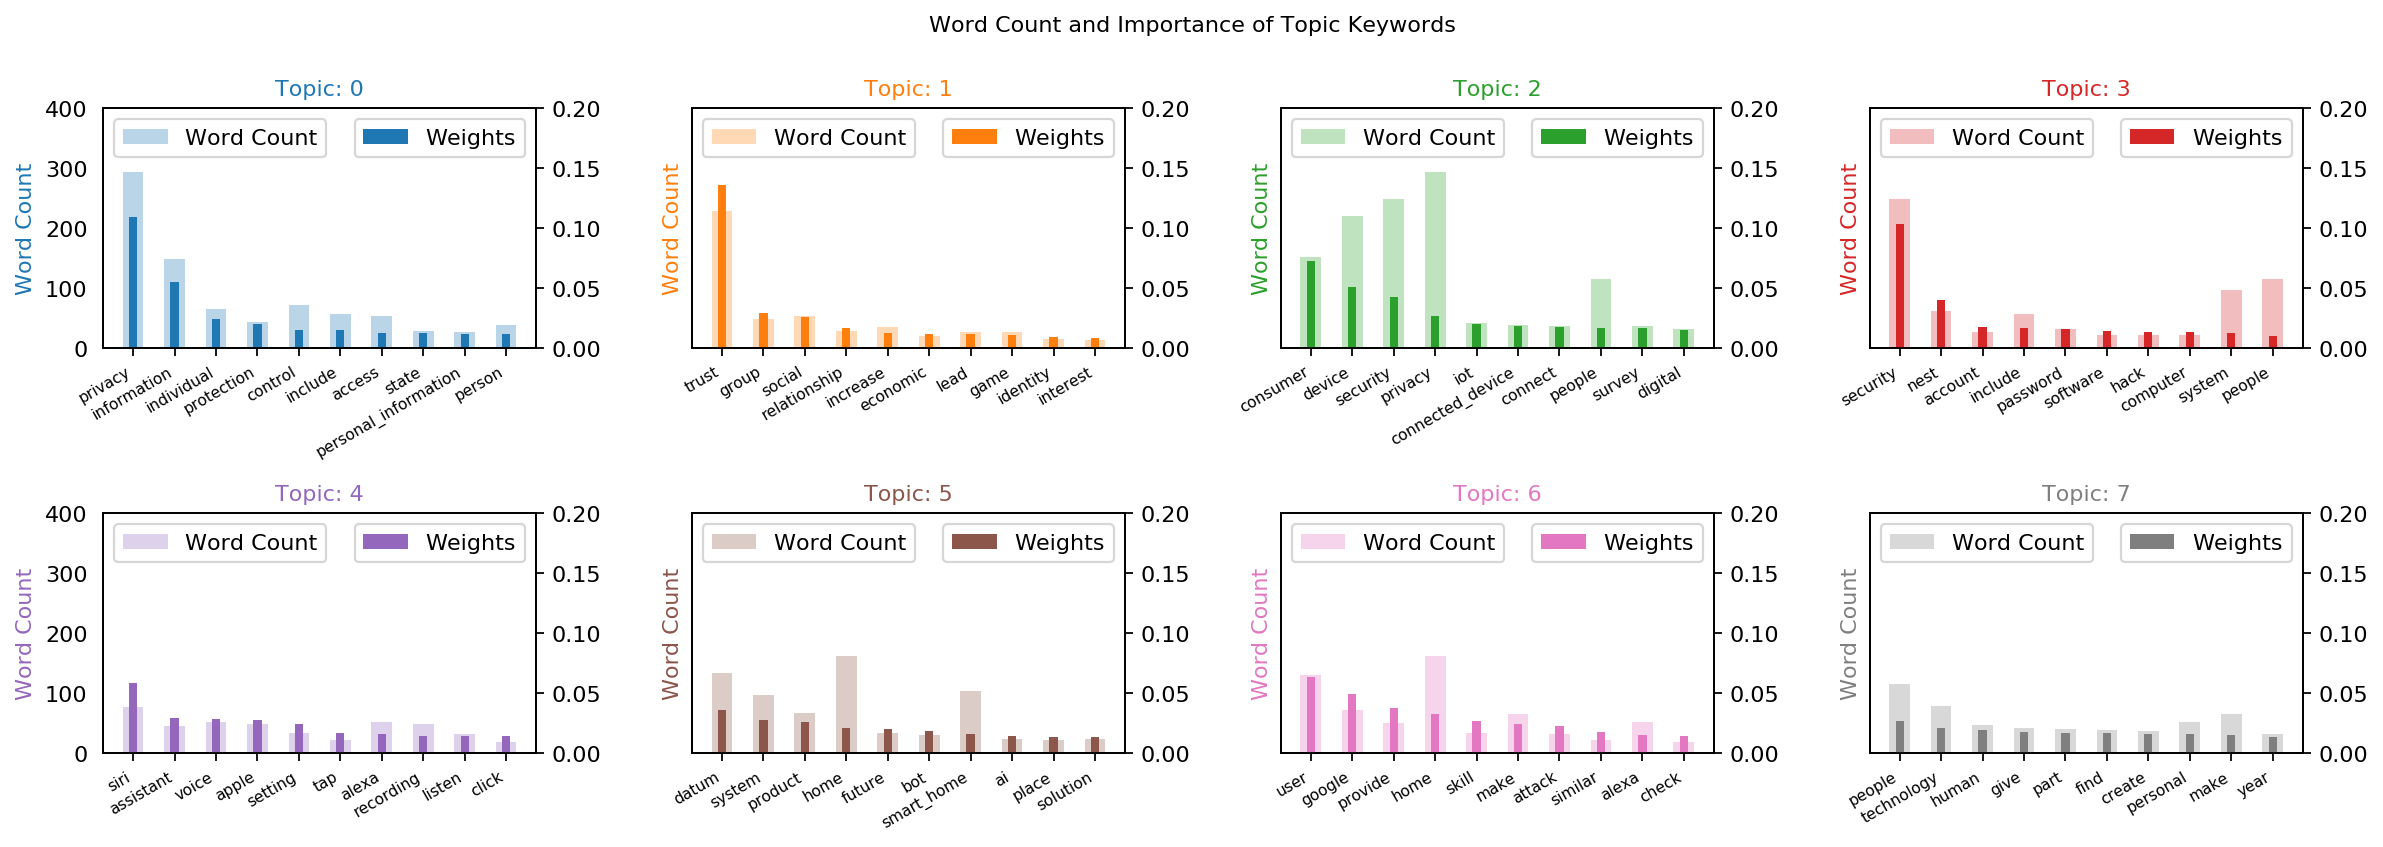

In [46]:
# Let's plot word counts and the weights of each keyword in the same chart
# Keep an eye on common words that occur in multiple topics and the one
# whose relative frequency is more than the weight. >> those should be added to stop_words

topics = optimal_model.show_topics(formatted=False)
data_flat = [word for page in train_words_lemmatized for word in page]

# words stored as dict keys and their count as dict values
counter = Counter(data_flat)

out = []
for num, dist in topics:
    # relative weight to the topic
    for word, weight in dist:
        out.append([word, num, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])    

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(15,5), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.20); ax.set_ylim(0, 400)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right', fontsize=7)
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)    
plt.show()